# **Aprendizaje Automático para Machine Learning**

## Actividad individual 1: "SUPPORT VECTOR MACHINE"

Fabio Santamaría Iglesias

05/07/2021

# **Introducción**

En esta práctica realizaremos clasificación de imágenes con Support Vector Machines. Para ello, utilizaremos dos datasets: MNIST y Fashion-MNIST. 

* MNIST 

  Es un dataset de dígitos de MNIST (Modified-NIST, del Instituto Nacional de Estándares y Tecnología de EEUU). Consta de 60.000 imágenes de entrenamiento y 10.000 de prueba. El tamaño de la imagen es de 28 x 28 píxeles. Cada imagen está etiquetada de 0 a 9 en función del dígito representado. Se utiliza como banco de pruebas para clasificar imágenes con algoritmos de Machine Learning. 

* Fashion-MNIST 

  Es un dataset de imágenes de artículos de moda de la empresa Zalando. Fue concebido para sustituir a MNIST porque requiere modelos de clasificación más complejos.  Mantiene las características de MNIST en cuanto a número de imágenes (60.000 de entrenamiento y 10.000 de prueba), tamaño de las imágenes (28 x 28 píxeles) y número de clases (10). Se diferencia en el contenido de las imágenes: 10 tipos de artículos de moda, en lugar de los 10 dígitos. 

El objetivo es comparar el resultado (accuracy) en función del dataset y el tipo de kernel SVM. Para ello, cargaremos ambos datasets desde tensorflow.
Después, aplicaremos un preprocesado con la finalidad de convertir las imágenes en vectores unidimensionales. Una vez hecho esto, aplicaremos un PCA para reducir la dimensionalidad del problema.

En concreto, usaremos el clasificador SVM de sklearn utilizando dos tipos de kernel: Lineal y Gausiano. Nos restringiremos a entrenar con 20.000 imágenes y aplicaremos las métricas con el dataset de prueba completo (10.000 imágenes). Por último, entrenaremos el modelo óptimo con todo el *dataset* disponible para sacarle el mejor partido.  

Para acortar el tiempo de entrenamiento con el kernel gaussiano, dejaremos el valor de gamma por defecto (“scale”), así como el valor de probability por defecto (“False”).

Comenzamos importando las librerías básicas con las que trabajaremos:

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## **Obtenición del dataset**

Cargamos los conjuntos de datos desde *tensorflow*:

In [28]:
import tensorflow as tf

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

## **Preprocesado de datos**

Para poder entrenar nuestro modelo, cambiamos la forma en la que está expresada la información, pasando todos los objetos 3D array a 2D array. De esta forma, las imágenes 28x28 quedan expresadas como filas de 784 columnas.

In [29]:
x_train_mnist = x_train_mnist.reshape(60000,-1)
x_test_mnist = x_test_mnist.reshape(10000,-1)

x_train_fashion = x_train_fashion.reshape(60000,-1)
x_test_fashion = x_test_fashion.reshape(10000,-1)

Se puede corroborar que efectivamente nuestra base de datos *mnist* contiene dígitos del 0 al 9:

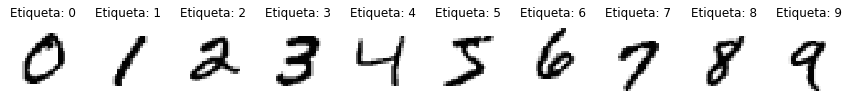

In [30]:
u, indices = np.unique(y_train_mnist, return_index=True)
X_u = x_train_mnist[indices]
y_u = y_train_mnist[indices]

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Etiqueta: %i' % label)

Similarmente, con *fashion-minst*:

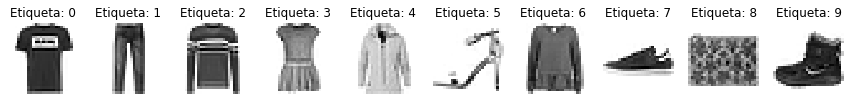

In [31]:
u, indices = np.unique(y_train_fashion, return_index=True)
X_u = x_train_fashion[indices]
y_u = y_train_fashion[indices]

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Etiqueta: %i' % label)

Comprobamos que los *dataset* no contienen ningún valor faltante:

In [32]:
np.any(np.isnan(y_train_mnist))

False

In [33]:
np.any(np.isnan(y_train_fashion))

False

In [34]:
np.any(np.isnan(x_train_mnist))

False

In [35]:
np.any(np.isnan(x_train_fashion))

False

In [36]:
np.any(np.isnan(y_test_mnist))

False

In [37]:
np.any(np.isnan(y_test_fashion))

False

In [38]:
np.any(np.isnan(x_test_mnist))

False

In [39]:
np.any(np.isnan(x_test_fashion))

False

Para la realización de esta tarea, usaremos solo 20.000 registros de cada conjunto de entrenamiento. Esto reduce el coste computacional para crear los modelos y nos permitirá explorar más posibilidades.

In [40]:
n_train = 20000 # registros a usar en entrenamiento
x_train_mnist_20000 = x_train_mnist[0:n_train]
x_train_fashion_20000 = x_train_fashion[0:n_train]

y_train_mnist_20000 = y_train_mnist[0:n_train]
y_train_fashion_20000 = y_train_fashion[0:n_train]

Lo primero es comprobar cómo de balanceados están los *dataset* resultantes:

In [41]:
pd.Series(y_train_mnist_20000).value_counts() / len(y_train_mnist_20000)

1    0.11405
7    0.10465
3    0.10380
9    0.10070
0    0.09970
6    0.09855
4    0.09725
2    0.09645
8    0.09610
5    0.08875
dtype: float64

In [42]:
pd.Series(y_train_fashion_20000).value_counts() / len(y_train_fashion_20000)

6    0.10340
9    0.10140
1    0.10125
3    0.10055
5    0.10050
7    0.10015
2    0.09910
8    0.09855
4    0.09835
0    0.09675
dtype: float64

Se observa que ambos conjuntos están aproximadamente balanceados. En ambos contamos con 10 clases, siendo mayoritaria la clase 1 para *mnist* (11,4%) y la clase 6 para *fashion_mnist* (10,3%). Por su parte, las clases que menos registros tienen se corresponden con la clase 5 (8,9%) y la clase 0 (9,7%), respectivamente. Por lo tanto, existe una desproporción relativamente pequeña entre la clase mayoritaria y la minoritaria de cada conjunto de datos, de menos del 2,6% para *mnist* y del 0.7% para *fashion_mnist*.

# **Selección del modelo SVM**



Una vez analizados los *dataset*, y viendo que no poseemos un conocimiento previo sobre los mismos, realizaremos una búsqueda de los mejores hiperparámetros para encontrar un modelo SVM adecuado. Para ello, nos valdremos de la función *GridSearchCV*, la cual realizará los ajustes sobre el conjunto de parámetros que especifiquemos. Así, probaremos con dos tipos de *kernel*, el lineal y el gaussiano, para diferentes valores de C. 

Aquí, tal y como indica la [API de la librería *SVC*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), C es un hiperparámetro de regularización. En concreto, la relevancia de la regularización es inversamente proporcional a C. Por lo tanto, a menor C más importancia da nuestro modelo a los puntos incorrectamente clasificados. Su valor debe ser positivo.

Antes de empezar, debemos mencionar que se ha comprobado que realizar esta búsqueda sobre tantos registros requiere unos recursos computaciones muy elevados y mucho tiempo de ejecución. Con la finalidad de emplear un tiempo razonable, aplicamos primeramente una reducción de dimensionalidad sobre el *dataset* usando el método PCA.

Así, lo primero es realizar un escalado de los datos, tipificándolos. De esta forma, nos aseguramos que todas las features (784) son tratadas de igual manera. Para esto, usamos el objeto *StandardScaler*, al cual le aplicamos la función *fit_transform* para aprender la conversión más adecuada de los datos de entrenamiento, y *transform* para transformar el conjunto de prueba, aplicando las reglas previamente aprendidas de *fit_transform*.

## MNIST

Empezamos con el dataset de dígitos mnist

### Tipificación de las catacterísticas

Usamos el objecto StandardScaler y su función *fit_transform* para aprender la conversión más adecuada de los datos de entrenamiento. Posteriormente, aplicamos la función *transform* sobre el conjunto de prueba:

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_mnist_20000_scaled = scaler.fit_transform(x_train_mnist_20000)
x_test_mnist_scaled = scaler.transform(x_test_mnist)

Se puede comprobar, por ejemplo, como la media y la varianza de la primera característica se reducen drásticamente:

In [44]:
print(x_train_mnist_20000[0].mean())
print(x_train_mnist_20000[0].var())

35.108418367346935
6343.935949539255


In [45]:
print(x_train_mnist_20000_scaled[0].mean())
print(x_train_mnist_20000_scaled[0].var())

0.04546077806502856
1.1354239367956749


### PCA

Finalmente, realizamos un PCA sobre los datos escalados:

In [46]:
from sklearn.decomposition import PCA

pca = PCA()
x_train_minst_20000_final = pca.fit_transform(x_train_mnist_20000_scaled)
x_test_mnist_final = pca.transform(x_test_mnist_scaled)

print(pca.explained_variance_ratio_)

[5.81775574e-02 4.29843046e-02 3.90283121e-02 2.97657240e-02
 2.59065473e-02 2.27433633e-02 2.01658131e-02 1.81206320e-02
 1.61917608e-02 1.46852206e-02 1.40009723e-02 1.22715468e-02
 1.15142319e-02 1.13090533e-02 1.08902901e-02 1.04645401e-02
 9.75561072e-03 9.59844468e-03 9.26520743e-03 9.15832000e-03
 8.71122872e-03 8.36737242e-03 7.95164043e-03 7.72453673e-03
 7.44983987e-03 7.22383400e-03 7.12917140e-03 6.87547994e-03
 6.70234711e-03 6.57725040e-03 6.37092103e-03 6.27567670e-03
 6.13575361e-03 5.97899542e-03 5.92499792e-03 5.79054551e-03
 5.64356602e-03 5.57342531e-03 5.46119056e-03 5.37822063e-03
 5.26599697e-03 4.93892757e-03 4.85284557e-03 4.80459914e-03
 4.74284551e-03 4.67569330e-03 4.60468274e-03 4.52211396e-03
 4.48376795e-03 4.40720644e-03 4.38864393e-03 4.22364534e-03
 4.20871991e-03 4.12676796e-03 4.04052204e-03 3.90702884e-03
 3.85102694e-03 3.80225603e-03 3.73317422e-03 3.69048260e-03
 3.63841880e-03 3.56436443e-03 3.55078717e-03 3.51884890e-03
 3.51113783e-03 3.401501

Como vemos, la componente principal representa cerca del 5,82% de la variabilidad total. Las sucesivas componentes van explicando en menor medida cada dato.

Si nos fijamos, hay un salto muy grande, pasando de $10 ^{-5}$ a $10 ^{-31}$, una diferencia de muchas órdenes de magnitud. Esto quiere decir que podremos reducir la dimensionalidad de nuestro conjunto de datos sin perder apenas representatividad. Probablemente esto se deba a las esquinas de las imágenes, cuyos píxeles esperamos que siempre estén en blanco. De hecho, podemos buscar a partir de qué componente se produce este salto:

In [47]:
print(len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > 0.00001]))

687


Este número nos sigue pareciendo algo elevado. Probemos a quedarnos con las primeras 500 componentes y veamos que conseguimos explicar más del 98% de la variabilidad de los datos del conjunto de entrenamiento:

In [48]:
sum(pca.explained_variance_ratio_[0:500])

0.9885214361090495

In [49]:
x_train_minst_20000_500_components_final = x_train_minst_20000_final[:,0:500]
x_test_mnist_500_components_final = x_test_mnist_final[:,0:500]

### Búsqueda del mejor modelo

A continuación, realizamos la búsqueda paramétrica sobre el conjunto de entrenamiento, introduciendo un C con los valores 1, 10, 100 y 1000 tanto para el kernel lineal como para el kernel gaussiano:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1, 10, 100, 1000],
              'kernel': ['rbf', 'linear']} 

grid = GridSearchCV(SVC(), param_grid)
grid.fit(x_train_minst_20000_500_components_final, y_train_mnist_20000)
best_params = grid.best_params_
print(f"Best params: {best_params}")

Best params: {'C': 10, 'kernel': 'rbf'}


Tras unos 45 minutos de ejecución, la función nos indica que el mejor modelo es aquel con kernel tipo gaussiano y con un valor C de 10. (Si hubiésemos optado por no realizar un PCA, la ejecución se demoraría más de 2 horas.)

No obstante, consideramos que este tiempo de entrenamiento es muy elevado y por tanto optamos por implementar explícitamente la búsqueda de forma que podamos medir el tiempo de entrenamiento, así como las principales métricas para cada modelo. Esto nos permitirá seleccionar un valor compromiso entre una alta *accuracy* y un tiempo de ejecución razonablemente pequeño.

Empezamos con el kernel gaussiano para diferentes valores de C:

Kernel Gaussiano con C = 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  01:46:756187
Precisión (accuracy):  0.9855
Matriz de confusión:
[[1988    0    0    0    1    1    3    0    0    1]
 [   0 2261    6    4    2    0    1    1    3    3]
 [   2    4 1910    2    1    0    1    5    3    1]
 [   0    3    7 2027    1   12    0   10   10    6]
 [   0    3    1    0 1921    0    2    1    0   17]
 [   2    1    1    9    3 1747    7    0    4    1]
 [   4    3    1    0    2    4 1954    0    3    0]
 [   0    4    3    0    7    0    0 2061    2   16]
 [   0   10    3    7    3    5    2    2 1884    6]
 [   3    3    0    8   18    3    1   17    4 1957]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      199

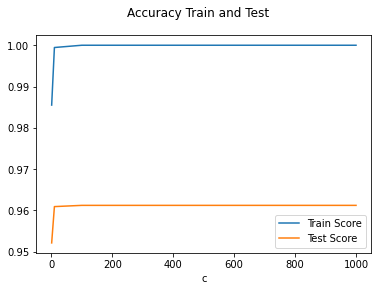

In [ ]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

minAccTrain = 100
maxAccTrain = 0
rapidoAccTrain = 0
lentoAccTrain = 0
minAccTest= 100
maxAccTest = 0
rapidoAccTest = 0
lentoAccTest = 0

mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

c_list = []
acc_train_list = []
acc_test_list = []

kernel = "rbf"

for c in (1, 10, 100, 1000):
    print("Kernel Gaussiano con C =", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c)
    print(modelo.fit(x_train_minst_20000_500_components_final, y_train_mnist_20000))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
    print("Tiempo entrenamiento: ", timeDiff)

    c_list.append(c)

    #para el conjunto de entrenamiento:
    acc_train = modelo.score(x_train_minst_20000_500_components_final, y_train_mnist_20000)
    acc_train_list.append(acc_train)
    print("Precisión (accuracy): ", acc_train)


    predicciones = modelo.predict(x_train_minst_20000_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_train_mnist_20000, predicciones))
    print(classification_report(y_train_mnist_20000, predicciones))
    print("---------------------------------------")
    print()

    #para el conjunto test:
    acc_test = modelo.score(x_test_mnist_500_components_final, y_test_mnist)
    acc_test_list.append(acc_test)
    print("Precisión (accuracy): ", acc_test)

    predicciones = modelo.predict(x_test_mnist_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_mnist, predicciones))
    print(classification_report(y_test_mnist, predicciones))
    print("---------------------------------------")
    print()

df = pd.DataFrame({"c":c_list, 
                   "score_train":acc_train_list,
                   "score_test":acc_test_list})

df.set_index("c", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Resumimos los resultados obtenidos de la *accuracy* para cada modelo usando el kernel gaussiano:

|    C  | tiempo de entrenamiento (mm:ss) | *Accuracy* en entrenamiento | *Accuracy* en test |
|---------------|:-------------:|:-------------:|:-------------:|
|   1    |      1:46     |         0.9855      |     0.9521      |
|   10  |      1:36     |         0.99945      |     0.9609      |
|   100    |     1:36     |         1      |      0.9612      |
|   1000    |     1:36     |         1     |      0.9612      |

Obtenemos resultados muy parecidos para los valores 10, 100 y 1000. Por contra, C = 1 da como resultado un valor más pequeño de la *accuracy* tanto en el conjunto de entrenamiento como en el conjunto de prueba.

Recordemos que, en este caso, C es inversamente proporcional al peso que tiene la regularización de los errores, es decir, al margen tenido en cuenta en la SVM. Otra forma de expresarlo es decir que C es inversamente proporcional a la importancia que le da el modelo a cometer errores de clasificación. 

Por ello, es lógico que para un valor pequeño de C veamos *underfitting* (mucho sesgo y poca variabilidad), ya que para dibujar las fronteras entre clases se están teniendo en cuenta un gran número de puntos. Esto impide encontrar el modelo con los mejores hiperplanos, pues para establecer cada separación se consideran puntos que puede que no estén cerca de la frontera. 

Por otro lado, vemos que valores grandes de C mantienen prácticamente la misma *accuracy*, siendo la precisión obtenida en el conjunto de entrenamiento aproximadamente del 100% y en el conjunto de prueba de un 96%. Aquí entramos en el terreno del *overfitting*. Como vemos, los errores de clasificación cuentan mucho y los hiperplanos se están ajustando demasiado a la frontera en el conjunto de entrenamiento y cometen algunos errores en el conjunto de prueba.

Junto con la *accuracy* se ha pintado la matriz de confusión, así como los principales indicadores: precision, recall y f1-score. Esto nos permite asegurarnos de que los modelos se comportan aproximadamente igual sobre las diferentes clases.

Por último, no se aprecia una diferencia en los tiempos de entrenamiento empleados por cada modelo.

Seguimos con el entrenamiento explícito para el kernel lineal:



Kernel Lineal con C = 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  00:49:892517
Precisión (accuracy):  0.99605
Matriz de confusión:
[[1994    0    0    0    0    0    0    0    0    0]
 [   0 2281    0    0    0    0    0    0    0    0]
 [   0    1 1923    1    0    0    0    0    4    0]
 [   0    0    2 2059    0    7    0    0    8    0]
 [   0    1    0    0 1941    0    0    0    0    3]
 [   0    0    1    5    0 1768    0    0    1    0]
 [   0    0    0    0    0    0 1971    0    0    0]
 [   0    0    0    1    1    0    0 2079    0   12]
 [   0    1    0    7    0    1    0    0 1913    0]
 [   0    2    0    0    8    0    0   12    0 1992]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      19

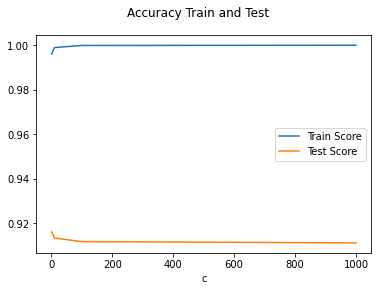

In [ ]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

minAccTrain = 100
maxAccTrain = 0
rapidoAccTrain = 0
lentoAccTrain = 0
minAccTest= 100
maxAccTest = 0
rapidoAccTest = 0
lentoAccTest = 0

mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

c_list = []
acc_train_list = []
acc_test_list = []

kernel = "linear"

for c in (1, 10, 100, 1000):
    print("Kernel Lineal con C =", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c)
    print(modelo.fit(x_train_minst_20000_500_components_final, y_train_mnist_20000))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
    print("Tiempo entrenamiento: ", timeDiff)

    c_list.append(c)

    #para el conjunto de entrenamiento:
    acc_train = modelo.score(x_train_minst_20000_500_components_final, y_train_mnist_20000)
    acc_train_list.append(acc_train)
    print("Precisión (accuracy): ", acc_train)


    predicciones = modelo.predict(x_train_minst_20000_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_train_mnist_20000, predicciones))
    print(classification_report(y_train_mnist_20000, predicciones))
    print("---------------------------------------")
    print()

    #para el conjunto test:
    acc_test = modelo.score(x_test_mnist_500_components_final, y_test_mnist)
    acc_test_list.append(acc_test)
    print("Precisión (accuracy): ", acc_test)

    predicciones = modelo.predict(x_test_mnist_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_mnist, predicciones))
    print(classification_report(y_test_mnist, predicciones))
    print("---------------------------------------")
    print()

df = pd.DataFrame({"c":c_list, 
                   "score_train":acc_train_list,
                   "score_test":acc_test_list})

df.set_index("c", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Al igual que antes, resumimos en una tabla los valores de la *accuracy* para el kernel lineal:

|    C  | tiempo de entrenamiento (mm:ss) | *Accuracy* en entrenamiento | *Accuracy* en test |
|---------------|:-------------:|:-------------:|:-------------:|
|   1    |      0:49     |         0.99605      |     0.916      |
|   10  |      1:01     |         0.99895      |     0.9132     |
|   100    |     1:29     |         0.9999      |      0.9116     |
|   1000    |     1:27     |         1     |      0.911     |

Como vemos, no hay una gran diferencia entre los valores de C usados. Aun así, se aprecia que conforme C aumenta la precisión en el conjunto de entrenamiento va aumentando mientras que en el de prueba disminuye, adentrándonos en la región de *overfitting*. Como ya hemos comentado, esto se corresponde con lo esperado, ya que C es inversamente proporcional al factor de regularización. Un C elevado implica que los errores del modelo cuentan mucho, y por tanto, el modelo tiende a sobreajustarse a los datos de entrenamiento, mejorando su *accuracy*.

En estos modelos tampoco se aprecia una diferencia en tiempos significativa. De igual forma, podemos ver en las matrices de confusión y en los indicadores de cada modelo ninguna clase sobresale especialmente sobre las demás.



### Mejor modelo SVM

Para elegir el mejor modelo nos fijamos en la *accuracy* obtenida sobre el conjunto prueba. Usar el *kernel gaussiano* mejora la precisión de los modelos para cualquier valor de C. Por tanto, descartamos el kernel lineal.

Para los modelos gaussianos se ha visto cómo la precisión sobre el conjunto de prueba se estabiliza alrededor del valor 96% con C = 10, 100 y 1000. Entre ellos, tampoco se ha observado una diferencia sustancial en tiempos de ejecución o diferente trato entre clases. Es muy difícil decantarnos por un modelo en concreto.

No obstante, con *GridSearchCV* obtuvimos que el mejor modelo tiene C = 10 y kernel tipo gaussiano. En principio, la *accuracy* que nos da este método es de mejor calidad, pues realiza una validación cruzada (5-fold por defecto) sobre el *dataset* de entrenamiento, que contiene el doble de registros que nuestro *dataset* prueba.

Por todo ello, establecemos como modelo aquel con C = 10 y *kernel gaussiano* y lo entrenamos sobre todo el dataset de entrenamiento para obtener el máximo potencial:

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  08:03:148099
Precisión (accuracy):  0.9837
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98  

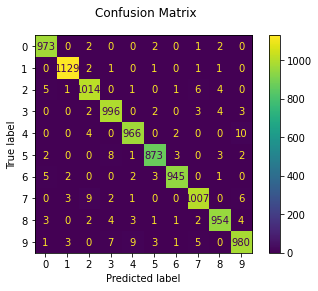

In [51]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report

timeIni = time()
modelo_mnist_final = SVC(kernel = 'rbf', C=10)
print(modelo_mnist_final.fit(x_train_mnist, y_train_mnist))
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
print("Tiempo entrenamiento: ", timeDiff)

#para el conjunto test:
acc_test = modelo_mnist_final.score(x_test_mnist, y_test_mnist)
print("Precisión (accuracy): ", acc_test)
disp = metrics.plot_confusion_matrix(modelo_mnist_final, x_test_mnist, y_test_mnist,  values_format = '')
disp.figure_.suptitle("Confusion Matrix")
predicciones = modelo_mnist_final.predict(x_test_mnist)
print(classification_report(y_test_mnist, predicciones))

Al usar todo el conjunto de entrenamiento hemos conseguido, tras 8 minutos, alcanzar una *accuracy* del 98,37% sobre el conjunto de prueba. Esto supone una mejora del 2% con respecto al modelo obtenido con 20.000 registros cuya dimensionalidad había sido reducida de 784 a 500 dimensiones para facilitar la búsqueda de los hiperparámetros óptimos.

Como vemos en la matriz de confusión, la inmensa mayoría de instancias han sido correctamente clasificadas, apareciendo predominantemente en la diagonal. Lo mismo se observa en los indicadores de *precision*, *recall* y *f1-score*.

## Fashion-MNIST

Aplicaremos los mismos pasos seguidos anteriormente para este *dataset*. Así, lo primero es tipificar las variables:

### Tipificación de las características

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_fashion_20000_scaled = scaler.fit_transform(x_train_fashion_20000)
x_test_fashion_scaled = scaler.transform(x_test_fashion)

In [ ]:
print(x_train_fashion_20000[0].mean())
print(x_train_fashion_20000[0].var())

97.25382653061224
10361.681745561747


In [ ]:
print(x_train_fashion_20000_scaled[0].mean())
print(x_train_fashion_20000_scaled[0].var())

0.32357839104381997
1.1724892831361209


### PCA

Después, reducir la dimensionalidad:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
x_train_fashion_20000_final = pca.fit_transform(x_train_fashion_20000_scaled)
x_test_fashion_final = pca.transform(x_test_fashion_scaled)

print(pca.explained_variance_ratio_)

[2.20331904e-01 1.44668852e-01 5.46335955e-02 5.13092931e-02
 4.01565960e-02 2.98837003e-02 2.76166567e-02 2.31495218e-02
 1.68293192e-02 1.35545479e-02 1.18420712e-02 9.64263309e-03
 9.24786683e-03 8.75639383e-03 7.54035828e-03 7.28842656e-03
 6.55114657e-03 6.42171397e-03 6.34574980e-03 5.87456576e-03
 5.57416231e-03 5.17632964e-03 4.76805770e-03 4.57919779e-03
 4.34559599e-03 4.18651814e-03 4.10627238e-03 3.96059091e-03
 3.84307749e-03 3.76000271e-03 3.73022326e-03 3.53014139e-03
 3.47116194e-03 3.34053937e-03 3.32220204e-03 3.22855325e-03
 3.10842188e-03 2.98673477e-03 2.88554919e-03 2.84035415e-03
 2.76712923e-03 2.74905070e-03 2.68599265e-03 2.52129276e-03
 2.49771494e-03 2.44133497e-03 2.39651782e-03 2.23816279e-03
 2.22572331e-03 2.17187239e-03 2.12075244e-03 2.07129034e-03
 2.02389069e-03 1.99965718e-03 1.96546628e-03 1.94482183e-03
 1.91526289e-03 1.88235105e-03 1.81213908e-03 1.79068035e-03
 1.71791717e-03 1.70157461e-03 1.69004264e-03 1.64793031e-03
 1.63438591e-03 1.579572

Al igual que antes, con 500 componentes conseguimos representar más del 98% de la variabilidad de nuestro conjunto de entrenamiento:

In [ ]:
sum(pca.explained_variance_ratio_[0:500])

0.9884430213069976

In [ ]:
x_train_fashion_20000_500_components_final = x_train_fashion_20000_final[:,0:500]
x_test_fashion_500_components_final = x_test_fashion_final[:,0:500]

### Búsqueda del mejor modelo

Si intentamos una búsqueda del mejor modelo usando *GridSearchCV*, nos encontraremos que, tras más de 4 horas de ejecución, la función no nos devuelve un resultado. Es por ello que entrenamos los modelos explícitamente con nuestro conjunto de entrenamiento sin realizar ninguna validación cruzada, usando el conjunto de prueba para validar nuestro modelo. Esto requerirá menos recursos aunque el valor para la *accuracy* no será tan fiable.

Empezamos con el kernel gaussiano para diferentes valores de C:

Kernel Gaussiano con C = 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  01:30:058862
Precisión (accuracy):  0.9145
Matriz de confusión:
[[1735    1   12   70    5    0  104    0    8    0]
 [   6 1976    4   35    1    0    3    0    0    0]
 [  20    0 1682   15  162    1  102    0    0    0]
 [  46    1   15 1873   41    0   29    0    6    0]
 [   1    0  107   62 1699    0   96    0    2    0]
 [   0    0    0    2    0 1956    0   45    2    5]
 [ 215    1  123   53  124    0 1545    0    6    1]
 [   0    0    0    0    0   36    0 1919    3   45]
 [   2    1    3    9    2    1    3    3 1946    1]
 [   0    0    0    1    0   14    0   54    0 1959]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      193

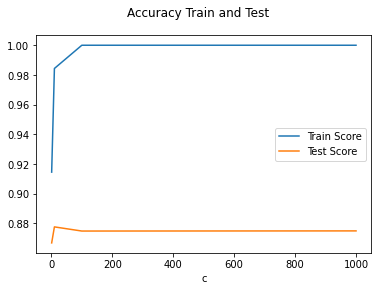

In [ ]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

minAccTrain = 100
maxAccTrain = 0
rapidoAccTrain = 0
lentoAccTrain = 0
minAccTest= 100
maxAccTest = 0
rapidoAccTest = 0
lentoAccTest = 0

mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

c_list = []
acc_train_list = []
acc_test_list = []

kernel = "rbf"

for c in (1, 10, 100, 1000):
    print("Kernel Gaussiano con C =", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c)
    print(modelo.fit(x_train_fashion_20000_500_components_final, y_train_fashion_20000))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
    print("Tiempo entrenamiento: ", timeDiff)

    c_list.append(c)

    #para el conjunto de entrenamiento:
    acc_train = modelo.score(x_train_fashion_20000_500_components_final, y_train_fashion_20000)
    acc_train_list.append(acc_train)
    print("Precisión (accuracy): ", acc_train)


    predicciones = modelo.predict(x_train_fashion_20000_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_train_fashion_20000, predicciones))
    print(classification_report(y_train_fashion_20000, predicciones))
    print("---------------------------------------")
    print()

    #para el conjunto test:
    acc_test = modelo.score(x_test_fashion_500_components_final, y_test_fashion)
    acc_test_list.append(acc_test)
    print("Precisión (accuracy): ", acc_test)

    predicciones = modelo.predict(x_test_fashion_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_fashion, predicciones))
    print(classification_report(y_test_fashion, predicciones))
    print("---------------------------------------")
    print()

df = pd.DataFrame({"c":c_list, 
                   "score_train":acc_train_list,
                   "score_test":acc_test_list})

df.set_index("c", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Resumimos los resultados obtenidos de la *accuracy* para cada modelo usando el kernel gaussiano:



|    C  | tiempo de entrenamiento (mm:ss) | *Accuracy* en entrenamiento | *Accuracy* en test |
|---------------|:-------------:|:-------------:|:-------------:|
|   1    |      1:30     |         0.9145      |     0.8668      |
|   10  |      1:22     |         0.98435      |     0.8776      |
|   100    |     1:23     |         1      |      0.8748      |
|   1000    |     1:24     |         1     |      0.8749      |

Al igual que con el *dataset* de dígitos, encontramos:

* Al incrementar C la precisión tanto en el conjunto de entrenamiento como el conjunto de test aumenta. Por tanto, para valores de C pequeños, los modelos presentan *underfitting* (mucho sesgo, poca varianza). Como ya explicamos, esto se debe a que C es inversamente proporcional al factor de regularización, con valores altos de C penalizando de forma más severa los errores y reduciendo el margen. Un C muy bajo, por tanto, tolera más clasificaciones erróneas y la SVM no es capaz de obtener los mejores hiperplanos ya que está teniendo en cuenta puntos alejados de las fronteras.

* No hay diferencias significativas en los tiempos de ejecución.

* Las matrices de confusión y los indicadores *precision*, *recall* y *f1-score* son similares entre los modelos, pero diferentes para cada clase en el conjunto de prueba. Así, las clases 1, 5 y 8 tienen valores mucho más altos de *f1-score* que las correspondientes a las 6, 4, 0 y 2. Por otro lado, no se aprecia diferencias grandes entre *precision* y *recall*, estando equilibrados ambos. 

Seguimos con el kernel lineal:

In [ ]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

minAccTrain = 100
maxAccTrain = 0
rapidoAccTrain = 0
lentoAccTrain = 0
minAccTest= 100
maxAccTest = 0
rapidoAccTest = 0
lentoAccTest = 0

mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

c_list = []
acc_train_list = []
acc_test_list = []

kernel = "linear"

for c in (1, 10, 100, 1000):
    print("Kernel Lineal con C =", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c)
    print(modelo.fit(x_train_fashion_20000_500_components_final, y_train_fashion_20000))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
    print("Tiempo entrenamiento: ", timeDiff)

    c_list.append(c)

    #para el conjunto de entrenamiento:
    acc_train = modelo.score(x_train_fashion_20000_500_components_final, y_train_fashion_20000)
    acc_train_list.append(acc_train)
    print("Precisión (accuracy): ", acc_train)


    predicciones = modelo.predict(x_train_fashion_20000_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_train_fashion_20000, predicciones))
    print(classification_report(y_train_fashion_20000, predicciones))
    print("---------------------------------------")
    print()

    #para el conjunto test:
    acc_test = modelo.score(x_test_fashion_500_components_final, y_test_fashion)
    acc_test_list.append(acc_test)
    print("Precisión (accuracy): ", acc_test)

    predicciones = modelo.predict(x_test_fashion_500_components_final)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_fashion, predicciones))
    print(classification_report(y_test_fashion, predicciones))
    print("---------------------------------------")
    print()

df = pd.DataFrame({"c":c_list, 
                   "score_train":acc_train_list,
                   "score_test":acc_test_list})

df.set_index("c", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Kernel Lineal con C = 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  02:20:413560
Precisión (accuracy):  0.93245
Matriz de confusión:
[[1794    0    3   31    0    0  107    0    0    0]
 [   0 2023    0    2    0    0    0    0    0    0]
 [  10    0 1686    5  175    0  106    0    0    0]
 [  23    0    2 1953   20    0   13    0    0    0]
 [   2    0  150   21 1688    0  106    0    0    0]
 [   0    0    0    0    0 1987    0   23    0    0]
 [ 206    3  153   30  114    0 1562    0    0    0]
 [   0    0    0    0    0   21    0 1974    0    8]
 [   0    0    0    0    0    0    0    0 1971    0]
 [   0    0    0    0    0    1    0   16    0 2011]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      19

Al igual que antes, resumimos los valores de *accuracy* y tiempos de ejecución para cada modelo en una tabla:

|    C  | tiempo de entrenamiento (mm:ss) | *Accuracy* en entrenamiento | *Accuracy* en test |
|---------------|:-------------:|:-------------:|:-------------:|
|   1    |      2:20     |         0.93245      |     0.8217      |
|   10  |      17:44     |         0.942      |     0.8157      |
|   100    |     35:42    |         0.94535      |      0.8133      |
|   1000    |     ---     |         ---    |      ---      |

Conforme aumenta C se observa que el tiempo necesario se incrementa sustancialmente, hasta el punto de no llegar a ser capaces de realizar el modelo C = 1000. Por su lado, la *accuracy* crece con C en el conjunto de entrenamiento y se hace más pequeña en el conjunto de prueba. Esto último nos indica que conforme aumentamos C nos vamos adentrando en la zona de *overfitting*, tal y como hemos comentado en los análisis anteriores.

De nuevo, las matrices de confusión y los indicadores *precision*, *recall* y *f1-score* nos muestran similitudes entre los modelos, pero diferencias para cada clase en el conjunto de prueba. Se ve que las clases 1, 5 y 8 tienen valores mucho más altos de *f1-score* que las correspondientes a las 6, 4, 0 y 2. Además, *precision* y *recall* vuelven a tener valores parecidos para cada clase.

Comparando entre kernels, el gaussiano mejora al lineal en más de un 4% para cualquier valor de C. Dentro de este kernel, encontramos que el valor máximo de *accuracy* se da para C = 10. Por ello, concluimos que nuestro modelo óptimo tendría un kernel gaussiano y un C = 10.

### Mejor modelo SVM

Tras el análisis anterior, construimos el modelo óptimo con C = 10 y *kernel gaussiano* y lo entrenamos sobre todo el dataset de entrenamiento para obtener el máximo potencial:

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Tiempo entrenamiento:  11:26:441688
Precisión (accuracy):  0.9002
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.83      0.83      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.72      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90  

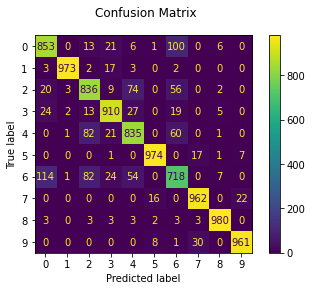

In [52]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report


modelo_fashion_final = SVC(kernel = 'rbf', C=10)
timeIni = time()
print(modelo_fashion_final.fit(x_train_fashion, y_train_fashion))
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")
print("Tiempo entrenamiento: ", timeDiff)

#para el conjunto test:
acc_test = modelo_fashion_final.score(x_test_fashion, y_test_fashion)
print("Precisión (accuracy): ", acc_test)
disp = metrics.plot_confusion_matrix(modelo_fashion_final, x_test_fashion, y_test_fashion, values_format = '')
disp.figure_.suptitle("Confusion Matrix")
predicciones = modelo_fashion_final.predict(x_test_fashion)
print(classification_report(y_test_fashion, predicciones))

El modelo tarda 11 minutos y 26 segundos en entrenar con todo el *dataset*, unas 10 veces más tiempo que el modelo análogo entrenado en nuestro análisis (1:22). La *accuracy* obtenida sobre el conjunto de prueba es del 90%, un 3% mejor. Recordemos que el modelo empleado en nuestro análisis fue entrenado sobre un conjunto de 20.000 registros (un tercio del total) y su dimensionalidad fue reducida de 784 a 500 dimensiones.

En cuanto a las métricas, vemos que en la matriz de confusión la inmensa mayoría de registros de prueba han sido correctamente clasificados, apareciendo predominantemente en la diagonal. Consecuentemente, los indicadores de *precision*, *recall* y *f1-score* muestran en general muy buenos en resultados.

En particular, se ve que las clases 6, 4, 0 y 2 se cometen más errores que para las clases 1, 5 y 9. Vemos que dichos errores son tanto por falsos positivos como por falsos negativos, ya que la *precision* y el *recall* tienen un valor parecido en todas las clases.



# **Conclusiones**

Recapitulando, en esta tarea se han implementado varios modelos SVM con dos *datasets*, uno basado en números escritos a mano y otro en imágenes de prendas de ropa.

Tras limitarnos a un subconjunto de entrenamiento de los datos disponibles (20.000 registros de 60.000) y reducir la dimensionalidad (de 784 a 500 dimensiones), se ha realizado una búsqueda de los hiperparámetros más adecuados para cada caso, variando para ello el tipo de kernel (lineal o gaussiano) y el valor de C (1, 10, 100, 1000)

Se ha visto que con valores de C muy pequeños se tiende a modelos con *underfitting* y con valores grandes a *overfitting*. En la implementación de la librería SVC, este parámetro es inversamente proporcional a la penalización asignada a los errores de clasificación. Consecuentemente, un valor pequeño de C permite un mayor grado de clasificaciones erróneas, haciendo posible que el algoritmo no separe correctamente las clases y se base en puntos muy alejados de las fronteras. Por su lado, un valor alto de C penaliza mucho los errores y se tiende a buscar hiperplanos muy ajustados al conjunto de entrenamiento.

A continuación, se ha considerado el tiempo de entrenamiento. Para los modelos con mejor *accuracy* en el conjunto de prueba, las diferencias entre los tiempos de ejecución son pequeñas, en ningún caso se han excedido los 2 minutos. Aquellos con C alto y kernel lineal, sobre todo en el conjunto *fashion_mnist*, presentan elevados tiempos de ejecución. Sin embargo, ninguno de estos modelos tiene una *accuracy* aceptable.

Después, se ha construido el mejor modelo SVM que hemos encontrado en el análisis exploratorio paramétrico y se ha aplicado sobre todo el *dataset* de entrenamiento disponible con la finalidad de sacar el mayor potencial posible a nuestros datos y así obtener la máxima *accuracy* sobre el conjunto de prueba. Tanto para el *dataset* de *mnist* como para el de *fashion_mnist*, el mejor modelo ha resultado ser aquel con *kernel* gaussiano y C = 10. Resumimos en la siguiente tabla los resultados obtenidos:



|    *dataset*  | tiempo de entrenamiento (mm:ss) | *Accuracy* en test |
|---------------|:-------------:|:-------------:|
|   mnist    |      8:03     |         0.9837      |
|   fashion_mnist  |      11:26     |         0.9002     |


Para el *dataset mnist* se ha obtenido una *accuracy* del 98,37% sobre el conjunto de prueba mientras que para el *fashion_mnist* se ha alcanzado el 90%. Al usar todos los datos disponibles, el tiempo de entrenamiento ha aumentado.

Con respecto a las métricas, la matriz de confusión y los indicadores *precision*, *recall*, y *f1-score* son muy buenos para el conjunto *mnist*. No se aprecian diferencias entre clases. Por contra, para *fashion_mnist*, sí se observan como las clases 1, 5 y 9 son mejor clasificadas que las clases 6, 4, 0 y 2. En principio, esto se debe a que los números son más diferenciables entre si que algunas prendas de ropa. 

Se concluye que las SVM son capaces de ofrecer un nivel de *accuracy* muy bueno comparado con otros algoritmos vistos durante el máster. En concreto, en el módulo 6 se aplicó un *Random Forest* para clasificar el conjunto de *mnist* llegando solo a una *accuracy* del 90%.